# Install Libraries

In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from IPython import display
import joblib

import time

import Helpers.show_results_helper as show

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Dataset

In [2]:
data_dir = 'data/mini_speech_commands_extracted/mini_speech_commands'

In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


## Preprocessing

In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


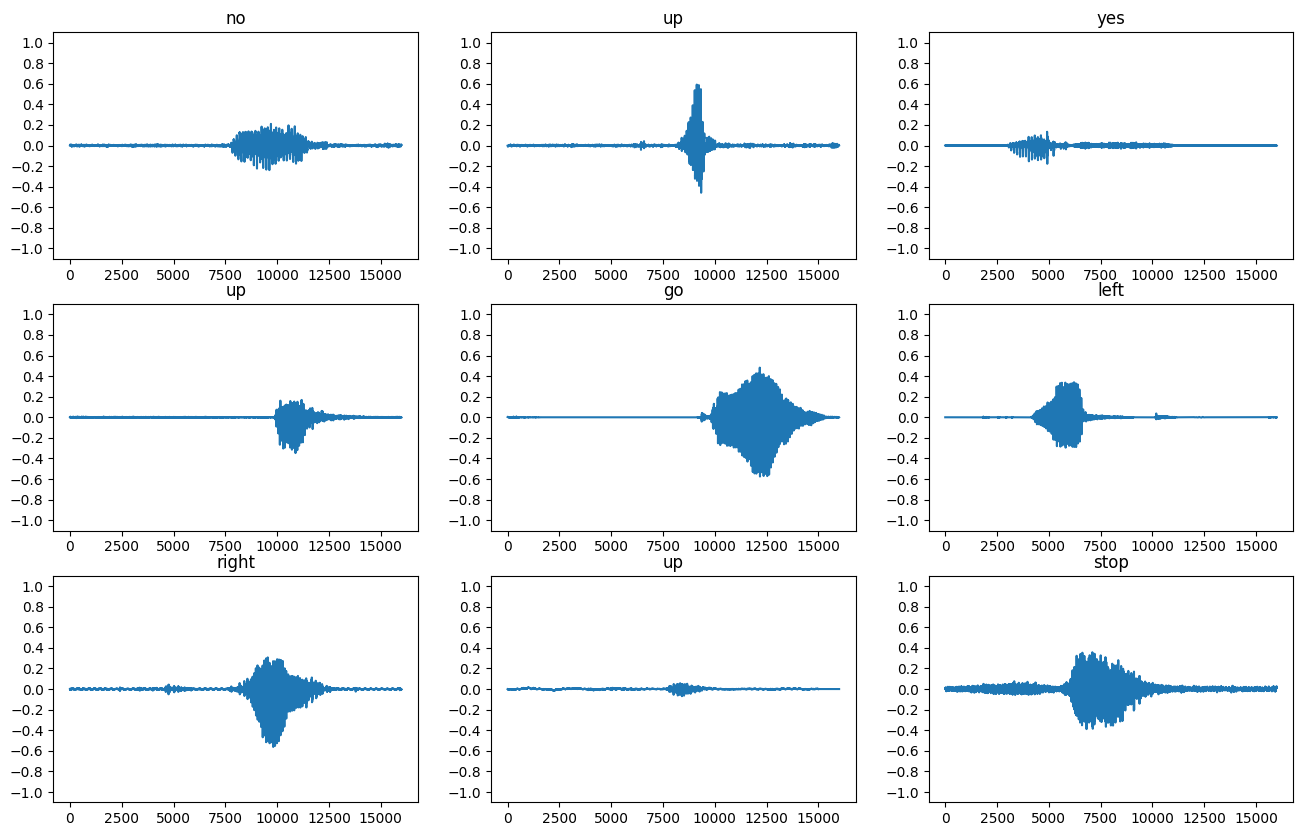

In [9]:
for example_audio, example_labels in train_ds.take(1):
    label_names = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
    plt.figure(figsize=(16, 10))
    rows = 3
    cols = 3
    n = rows * cols
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        audio_signal = example_audio[i]
        plt.plot(audio_signal)
        plt.title(label_names[example_labels[i]])
        plt.yticks(np.arange(-1.2, 1.2, 0.2))
        plt.ylim([-1.1, 1.1])

In [10]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [11]:
for i in range(10):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [10]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

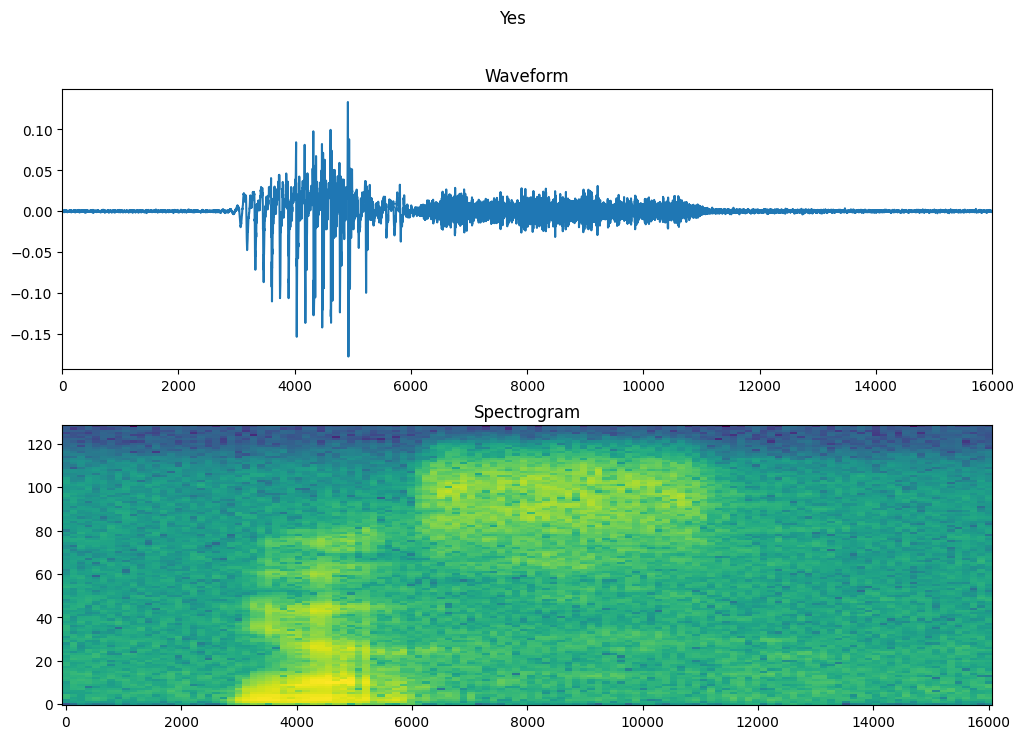

In [11]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [12]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

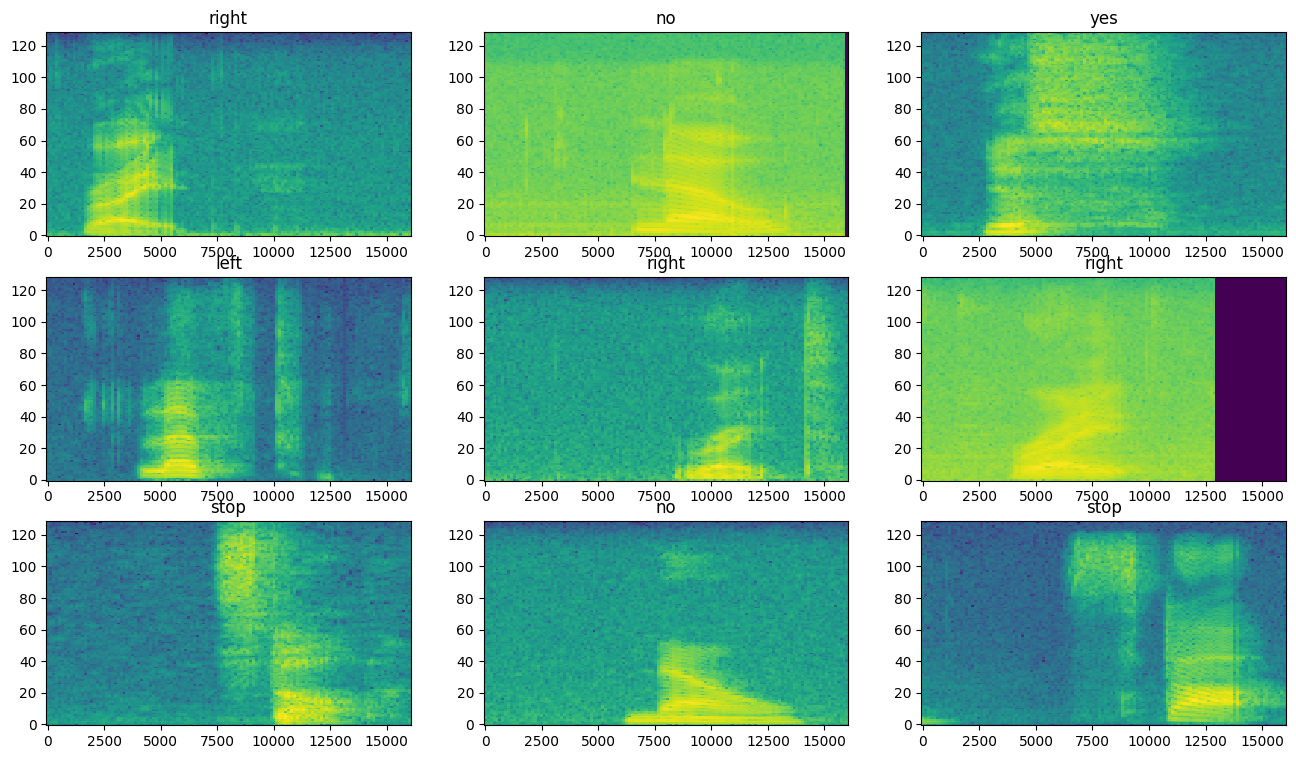

In [14]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  rows = 3
  cols = 3
  n = rows*cols
  fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

  for i in range(n):
      r = i // cols
      c = i % cols
      ax = axes[r][c]
      plot_spectrogram(example_spectrograms[i].numpy(), ax)
      ax.set_title(label_names[example_spect_labels[i].numpy()])

  plt.show()

In [15]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# Train

In [16]:
results = {}
created_models = {}

In [17]:
def get_callbacks(model_name):
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=6,  restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'Models/{model_name}.keras', save_best_only=True, monitor='val_accuracy', mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    return [early_stopping, checkpoint, reduce_lr]

In [30]:
def train(model, learning_rate=0.001):
    
    print(f"Start train {model.name}")

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    start = time.time()

    history = model.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=60,
        callbacks=get_callbacks(model.name),
        verbose = 0
    )

    end = time.time()
    train_time = end - start

    res = model.evaluate(test_spectrogram_ds, return_dict=True, verbose=0)

    print(f'Test accuracy: {res['accuracy']: .2%}, epochs: {len(history.history['accuracy'])}, time: {train_time / 60: .2f}m')
    print()

    results[model.name] = {
                "accuracy": history.history['accuracy'],
                "val_accuracy": history.history['val_accuracy'],
                "loss": history.history['loss'],
                "val_loss": history.history['val_loss'],
                "test_accuracy": res['accuracy'],
                "epochs": len(history.history['accuracy']),
                "train_time": train_time
    }

    created_models[model.name] = model

    return res['accuracy']

In [19]:
def create_model(input_shape=(124, 129, 1), num_labels=8, use_batch_norm=False, use_dropout=True, 
                 num_conv_layers=2, num_dense_layers=1, conv_filters=32, conv_kernel_size=3,
                 dense_units=128, dropout_rates=0.25):
    
    model_params = 'model_'

    model_params += f"BN{'Y' if use_batch_norm else 'N'}_"
    model_params += f"DR{'Y' if use_dropout else 'N'}_"

    model_params += f"conv{num_conv_layers}_f{conv_filters}_k{conv_kernel_size}_"
    model_params += f"dense{num_dense_layers}_units{dense_units}_"
    if use_dropout:
        model_params += f'drop{dropout_rates}_'

    model_name = model_params[:-1]

    norm_layer = layers.Normalization()
    norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(32, 32),
        norm_layer,
    ], name = model_name)


    for i in range(num_conv_layers):
        model.add(layers.Conv2D(conv_filters, (conv_kernel_size, conv_kernel_size), activation='relu'))
        if use_batch_norm:
            model.add(layers.BatchNormalization())
        if i > 0:
            model.add(layers.MaxPooling2D())
        conv_filters = conv_filters * 2
    
    if use_dropout:
        model.add(layers.Dropout(dropout_rates))
        

    model.add(layers.Flatten())

    for i in range(num_dense_layers):
        model.add(layers.Dense(dense_units, activation='relu'))
        if use_dropout:
            model.add(layers.Dropout(dropout_rates * 2))
        dense_units = int(dense_units / 2)

    model.add(layers.Dense(num_labels, activation='softmax'))
    
    return model

## Iterative experiments

### Stage 1

In [20]:
batch_norm = [True, False]
dropout = [True, False]
best_acc = 0
best = None
for b in batch_norm:
    for d in dropout:

        model = create_model(use_batch_norm=b, use_dropout=d)
        new_acc = train(model)

        if new_acc > best_acc:
            best_acc = new_acc
            best = f'batch_norm: {b}, dropout: {d}'

print(f'Stage 1: best conf {best}')

Start train model_BNY_DRY_conv2_f32_k3_dense1_units128_drop0.25
Test accuracy:  82.81%, epochs: 40, time:  6.37m

Start train model_BNY_DRN_conv2_f32_k3_dense1_units128
Test accuracy:  84.62%, epochs: 23, time:  3.68m

Start train model_BNN_DRY_conv2_f32_k3_dense1_units128_drop0.25
Test accuracy:  85.82%, epochs: 29, time:  2.86m

Start train model_BNN_DRN_conv2_f32_k3_dense1_units128
Test accuracy:  85.22%, epochs: 21, time:  1.90m

Stage 1: best conf batch_norm: False, dropout: True


### Stage 2

In [26]:
batch_norm = False
dropout = True

best_acc = 0
best = None

num_conv_layers = [1, 2, 3]
conv_filters = [16, 32, 64]
conv_kernel_size = [3, 5, 7]

for n_layers in num_conv_layers:
    for filters in conv_filters:
        for kernel_size in conv_kernel_size:

            model = create_model(use_batch_norm=batch_norm, use_dropout=dropout,
                                 num_conv_layers=n_layers, conv_filters=filters, conv_kernel_size=kernel_size)
            
            new_acc = train(model)

            if new_acc > best_acc:
                best_acc = new_acc
                best_config = f'num_conv_layers: {n_layers}, conv_filters: {filters}, conv_kernel_size: {kernel_size}'

print(f'Stage 2: best conf {best_config}')

Start train model_BNN_DRY_conv1_f16_k3_dense1_units128_drop0.25
Test accuracy:  75.60%, epochs: 21, time:  0.90m

Start train model_BNN_DRY_conv1_f16_k5_dense1_units128_drop0.25
Test accuracy:  78.12%, epochs: 29, time:  1.12m

Start train model_BNN_DRY_conv1_f16_k7_dense1_units128_drop0.25
Test accuracy:  80.05%, epochs: 24, time:  0.81m

Start train model_BNN_DRY_conv1_f32_k3_dense1_units128_drop0.25
Test accuracy:  75.60%, epochs: 29, time:  2.36m

Start train model_BNN_DRY_conv1_f32_k5_dense1_units128_drop0.25
Test accuracy:  78.12%, epochs: 25, time:  1.77m

Start train model_BNN_DRY_conv1_f32_k7_dense1_units128_drop0.25
Test accuracy:  79.21%, epochs: 29, time:  1.81m

Start train model_BNN_DRY_conv1_f64_k3_dense1_units128_drop0.25
Test accuracy:  77.04%, epochs: 23, time:  3.65m

Start train model_BNN_DRY_conv1_f64_k5_dense1_units128_drop0.25
Test accuracy:  80.41%, epochs: 36, time:  5.02m

Start train model_BNN_DRY_conv1_f64_k7_dense1_units128_drop0.25
Test accuracy:  80.41%, 

### Stage 3

In [29]:
batch_norm = False
dropout = True
n_layers = 3
filters = 32
kernel_size = 3

best_acc = 0
best = None

dense_units = [64, 128, 256, 512]
dropout_rates = [0.1, 0.15, 0.25, 0.35]

for units in dense_units:
    for rate in dropout_rates:

        model = create_model(use_batch_norm=batch_norm, use_dropout=dropout,
                                 num_conv_layers=n_layers, conv_filters=filters, conv_kernel_size=kernel_size,
                                 dense_units=units, dropout_rates=rate)
        

        new_acc = train(model)

        if new_acc > best_acc:
            best_acc = new_acc
            best_config = f'dense_units: {units}, dropout_rates: {rate}'

print(f'Stage 3: best conf {best_config}')

Start train model_BNN_DRY_conv3_f32_k3_dense1_units64_drop0.1
Test accuracy:  89.90%, epochs: 31, time:  3.23m

Start train model_BNN_DRY_conv3_f32_k3_dense1_units64_drop0.15
Test accuracy:  90.62%, epochs: 30, time:  3.15m

Start train model_BNN_DRY_conv3_f32_k3_dense1_units64_drop0.25
Test accuracy:  89.18%, epochs: 27, time:  2.83m

Start train model_BNN_DRY_conv3_f32_k3_dense1_units64_drop0.35
Test accuracy:  90.62%, epochs: 35, time:  3.67m

Start train model_BNN_DRY_conv3_f32_k3_dense1_units128_drop0.1
Test accuracy:  89.78%, epochs: 22, time:  2.41m

Start train model_BNN_DRY_conv3_f32_k3_dense1_units128_drop0.15
Test accuracy:  89.06%, epochs: 21, time:  2.29m

Start train model_BNN_DRY_conv3_f32_k3_dense1_units128_drop0.25
Test accuracy:  91.35%, epochs: 29, time:  3.24m

Start train model_BNN_DRY_conv3_f32_k3_dense1_units128_drop0.35
Test accuracy:  90.50%, epochs: 33, time:  3.55m

Start train model_BNN_DRY_conv3_f32_k3_dense1_units256_drop0.1
Test accuracy:  89.66%, epochs:

### Stage 4

In [35]:
batch_norm = False
dropout = True
n_layers = 3
filters = 32
kernel_size = 3
dense_units = 256
dropout_rates = 0.25

best_acc = 0
best_config = None

learning_rates = [0.005, 0.001, 0.0005, 0.0001]

for learning_rate in learning_rates:
    model = create_model(use_batch_norm=batch_norm, use_dropout=dropout,
                                num_conv_layers=n_layers, conv_filters=filters, conv_kernel_size=kernel_size,
                                dense_units=dense_units, dropout_rates=dropout_rates)
    
    model.name = f'final_model_lr_{learning_rate}'

    new_acc = train(model, learning_rate=learning_rate)

    if new_acc > best_acc:
        best_acc = new_acc
        best_config = f'learning_rate: {learning_rate}'

print(f'Stage 4: best conf {best_config}')

Start train final_model_lr_0.005
Test accuracy:  90.14%, epochs: 32, time:  4.02m

Start train final_model_lr_0.001
Test accuracy:  91.23%, epochs: 21, time:  2.70m

Start train final_model_lr_0.0005
Test accuracy:  90.75%, epochs: 29, time:  3.85m

Start train final_model_lr_0.0001
Test accuracy:  85.22%, epochs: 41, time:  5.54m

Stage 4: best conf learning_rate: 0.001


### Stage 4.2 
Test BatchNormalization again

In [36]:
dropout = True
n_layers = 3
filters = 32
kernel_size = 3
dense_units = 256
dropout_rates = 0.25
learning_rate = 0.001

batch_norm = True

model = create_model(use_batch_norm=batch_norm, use_dropout=dropout,
                                num_conv_layers=n_layers, conv_filters=filters, conv_kernel_size=kernel_size,
                                dense_units=dense_units, dropout_rates=dropout_rates)
    
model.name = f'final_model_lr_{learning_rate}_BNY'

new_acc = train(model, learning_rate=learning_rate)

Start train final_model_lr_0.001_BNY
Test accuracy:  90.50%, epochs: 29, time:  6.86m



# Save and Load

In [16]:
def load_models_from_folder(folder_path='Models'):

    m = {}
    for model_name in os.listdir(folder_path):
        model_path = os.path.join(folder_path, model_name)
        try:
            m[model_name[:-6]] = tf.keras.models.load_model(model_path)
        except Exception as e:
            print(f"Error loading model '{model_name}': {e}")
    return m

def save_models_to_folder(models_dict, folder_path='Models'):

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for model_name, model in models_dict.items():
        model_path = os.path.join(folder_path, model_name)
        try:
            model.save(f'{model_path}.keras')
        except Exception as e:
            print(f"Error saving model '{model_name}': {e}")

## Save

In [20]:
joblib.dump(results, 'data/results.pkl')

['data/results.pkl']

In [46]:
best = 0
best_name = ''

for name, metr in results.items():
   
    new = metr['test_accuracy']

    if new > best:
        best = new
        best_name = name

model = created_models[best_name]
model.name = 'final_model'
model.save(f'Models/{model.name}.keras')

In [70]:
save_models_to_folder(created_models)

## Load

In [17]:
models_dict = load_models_from_folder()

In [18]:
results = joblib.load('data/results.pkl')

# Results

## Show

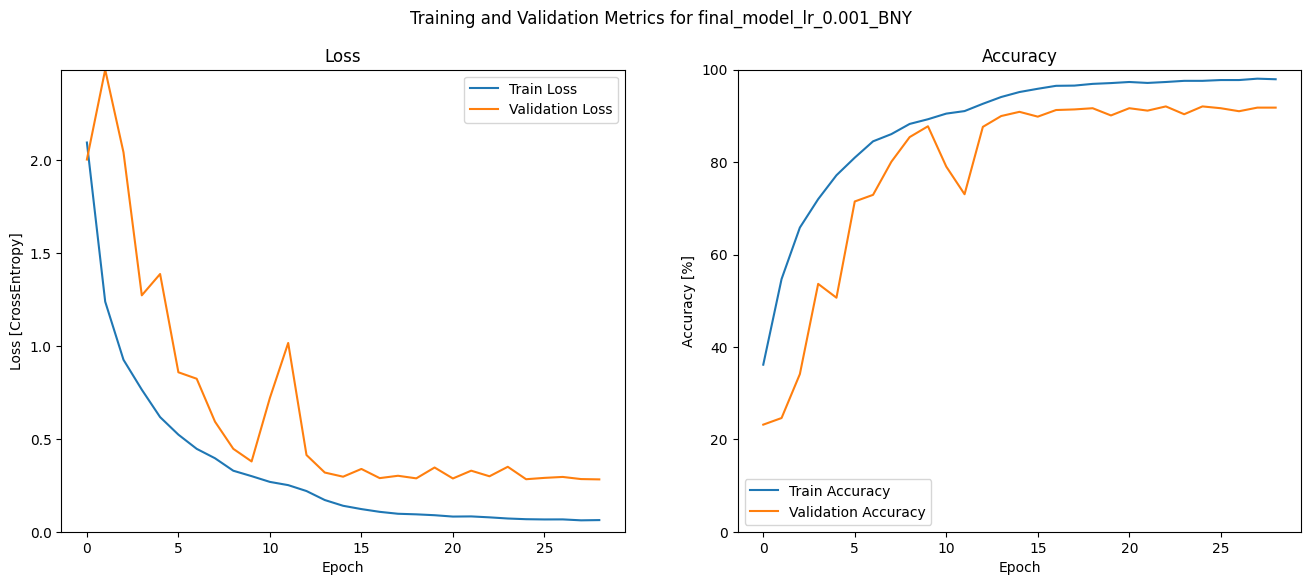

In [19]:

for n, r in results.items():
    if n == 'final_model_lr_0.001_BNY':
        show.plot_model_results(n, r)
        break

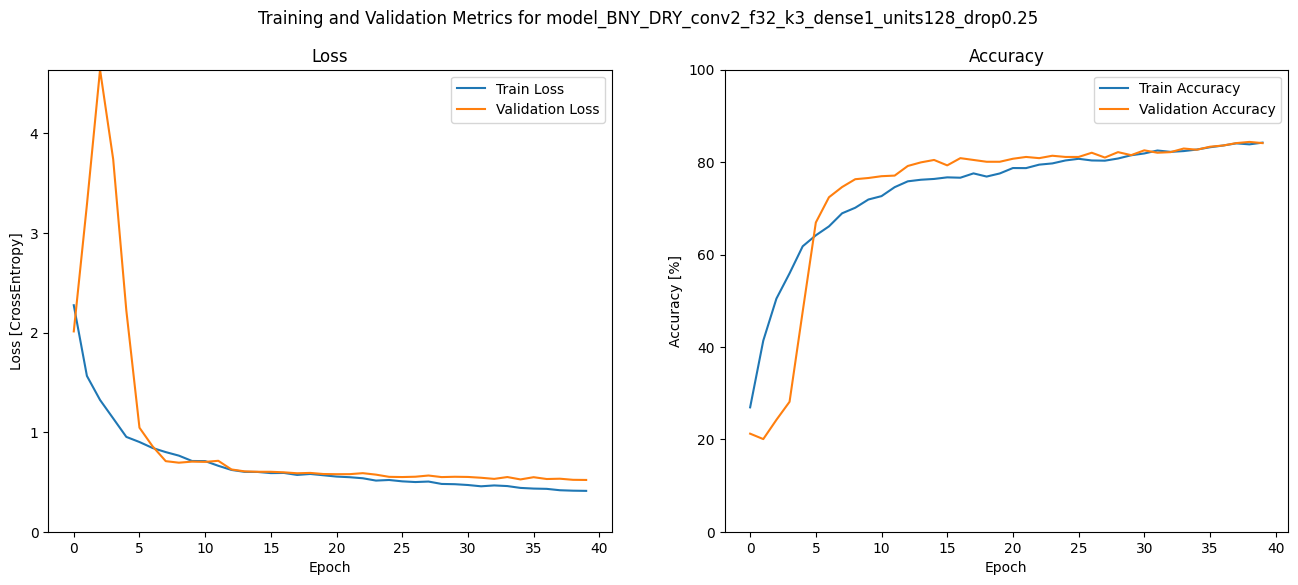

In [20]:
for n, r in results.items():
    
    show.plot_model_results(n, r)
    break

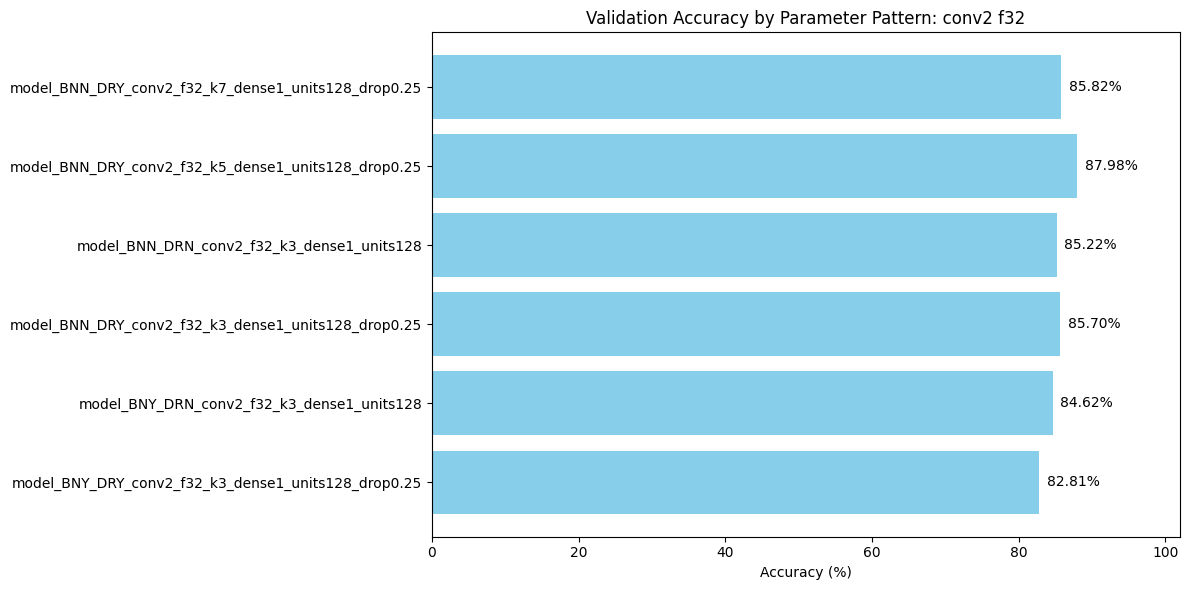

In [21]:
show.plot_bar_by_parameter(results, param_pattern='conv2 f32')

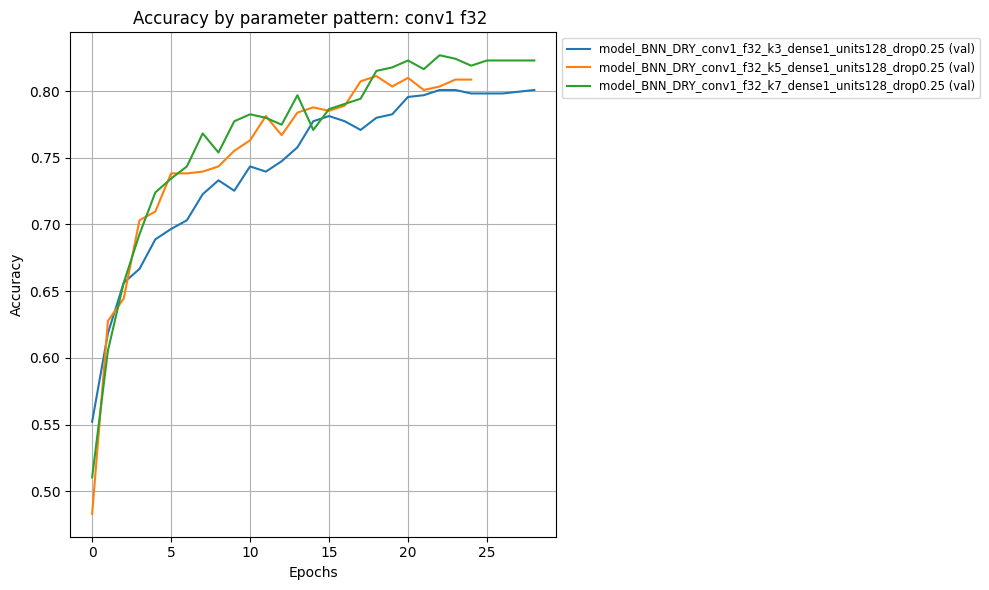

In [57]:
show.plot_metric_by_parameter(results, param_pattern='conv1 f32 ')

In [22]:
print(show.get_top_models(results))

TypeError: 'float' object is not iterable

## Test final

In [23]:
model = models_dict['final_model']

In [25]:
res = model.evaluate(test_spectrogram_ds, verbose=0)
print(f'Accuracy {res[1]:.2%}, Loss {res[0]:.4f}')

Accuracy 92.19%, Loss 0.2970


In [26]:
y_pred = model.predict(test_spectrogram_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [28]:
y_pred[0]

array([1.2572347e-17, 3.6207620e-13, 6.4637072e-07, 3.7065692e-17,
       1.3139527e-12, 9.7311957e-11, 9.9999940e-01, 4.0011042e-13],
      dtype=float32)

In [29]:
y_pred = tf.argmax(y_pred, axis=1)

In [33]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

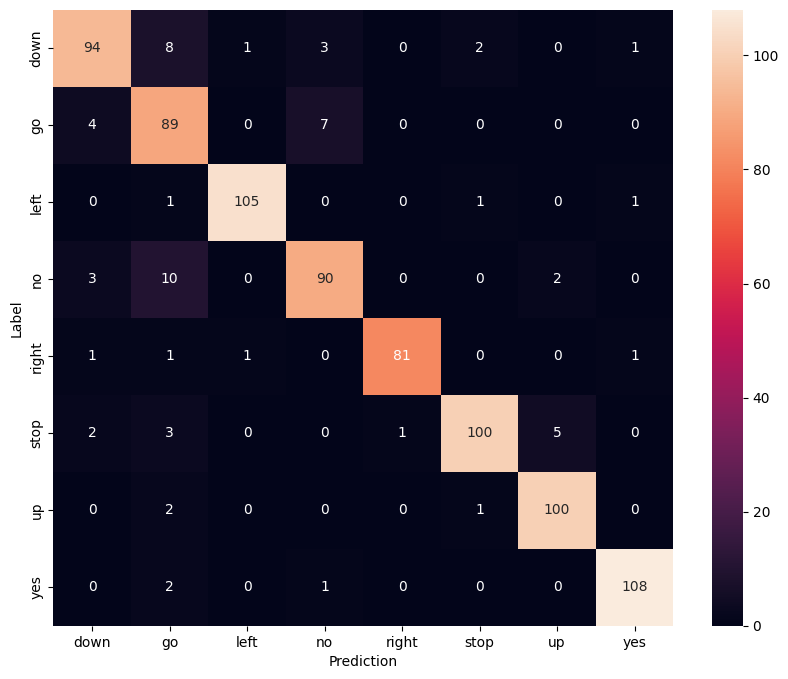

In [34]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

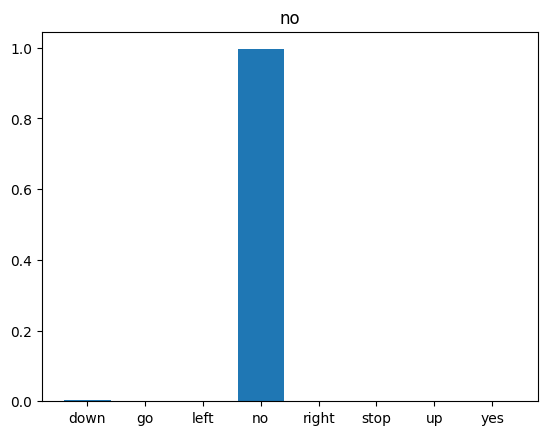

In [41]:
x = data_dir + '/no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.bar(x_labels, prediction[0])
plt.title('no')
plt.show()

display.display(display.Audio(waveform, rate=16000))